(sec:ml)=
# Machine learning

[PyTorch](https://en.wikipedia.org/wiki/PyTorch) is an open source machine learning (ML) framework based on the Python programming language and the Torch library. 

In [1]:
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. We will use a TorchVision dataset named MNIST.

## Data set

The [MNIST data set](https://en.wikipedia.org/wiki/MNIST_database) consists of 28 x 28 pixel greyscale images of handwritten digits, along with labels for each image indicating which digit it represents. The data set has 60,000 images. 

![MNIST handwritten numbers](../images/MnistExamplesModified.png)

### Loading dataset

In [3]:
mnist_dataset = torchvision.datasets.MNIST(
    root="../data_input/",
    download=True,
    train=True,
    transform=torchvision.transforms.ToTensor(),
)
print(mnist_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
idx_random_tensor = np.random.randint(60000)

In [5]:
tensor, label = mnist_dataset[idx_random_tensor]

print("Label:", label)
print("Dataset item:", idx_random_tensor)
print("Tensor shape:", tensor.shape)

Label: 5
Dataset item: 42935
Tensor shape: torch.Size([1, 28, 28])


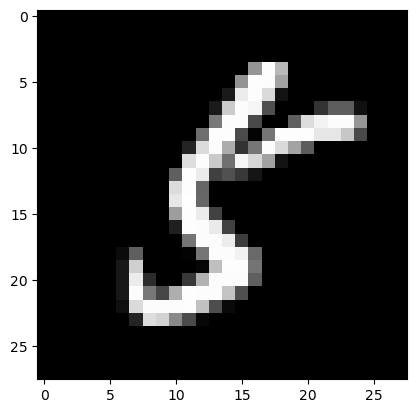

In [6]:
plt.imshow(tensor[0, :, :], cmap="gray")

plt.show()

### Split data set into subsets

In machine learning, [data sets are typically divided into the three categories](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) of training, validation, and test. We will divide data into two categories and skip the model tuning in the validation step. 

In [7]:
training_data, test_data = torch.utils.data.random_split(mnist_dataset, [50000, 10000])

We create data loaders to be able to load the data in batches. 

The shuffle option is set for the training data loader, so that the batches generated in each epoch are different. As the validation data loader is used only for evaluating the model, there is no need to shuffle these data.

In [8]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

## Neural network model

### Setting up the model

In [9]:
class MnistModel(torch.nn.Module):

    input_layer_dim = 28 * 28
    hidden_layer_dim = 512
    number_classes = 10

    def __init__(self):
        super().__init__()

        self.linear_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(self.input_layer_dim, self.hidden_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_layer_dim, self.hidden_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_layer_dim, self.number_classes),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [10]:
model = MnistModel()

In [11]:
print(model)

MnistModel(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Model assessment

A loss function is defined to quantify the model output from the reference. 

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

With this loss function, we determine the averaged loss and the percentage of correct predictions.

In [13]:
def test(dataloader, model):

    size = len(dataloader.dataset)  # size is 10,000 in our case

    model.eval()
    total_loss, number_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # X is batch_size number of tensors and y are the associated labels
            Y = model(X)
            total_loss += loss_fn(Y, y).item()
            number_correct += (Y.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * number_correct / size  # in percent
    averaged_loss = total_loss / size

    print(f"Averaged loss test data set    :{averaged_loss:9.6f}")
    print(f"Accuracy: {accuracy:>0.1f}%")

    return accuracy

### Initial model performance

With random parameters, we expect to prediction success of about 10%.

In [14]:
accuracy = test(test_dataloader, model)

prediction_accuracies = [accuracy]  # saved in list for plotting

Averaged loss test data set    : 0.144075
Accuracy: 9.8%


### Model training

In [15]:
number_of_epochs = 3  # number of iterations in the training

learning_rate = 0.01  # step length in gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)

    total_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        Y = model(X)
        loss = loss_fn(Y, y)
        total_loss += loss.item()

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Averaged loss training data set:{total_loss / size:9.6f}")

In [17]:
for epoch in range(number_of_epochs):

    print(f"Epoch {epoch+1}:")

    train(train_dataloader, model, loss_fn, optimizer)

    prediction_accuracies.append(test(test_dataloader, model))

print("Done!")

Epoch 1:
Averaged loss training data set: 0.047396
Averaged loss test data set    : 0.021573
Accuracy: 90.2%
Epoch 2:
Averaged loss training data set: 0.018759
Averaged loss test data set    : 0.016909
Accuracy: 92.3%
Epoch 3:
Averaged loss training data set: 0.014849
Averaged loss test data set    : 0.014112
Accuracy: 93.6%
Done!


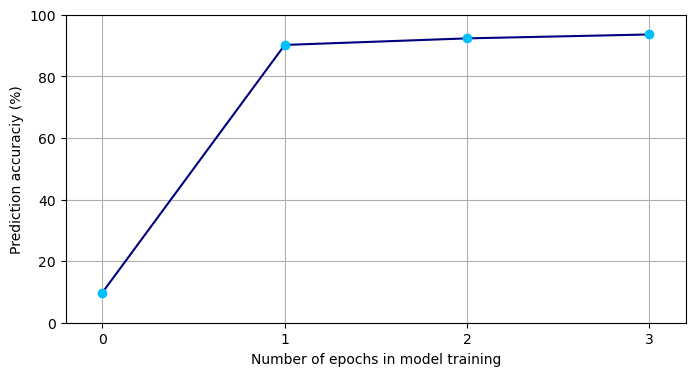

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(prediction_accuracies, "-", color="navy")
ax.plot(prediction_accuracies, "o", color="deepskyblue")

ax.set_xticks(range(0, number_of_epochs + 1))
ax.set_ylim((0, 100))
ax.set_xlim((-0.2, number_of_epochs + 0.2))
ax.grid(True)

ax.set_xlabel("Number of epochs in model training")
ax.set_ylabel("Prediction accuraciy (%)")

plt.show()

## Single image prediction

In [19]:
def predict_image(tensor, model):

    y = model(tensor)

    _, prediction = torch.max(y, dim=1)

    return prediction[0].item()

In [20]:
idx_random_tensor = np.random.randint(10000)

Testing data set item: 8208
Label: 4
Predicted : 4


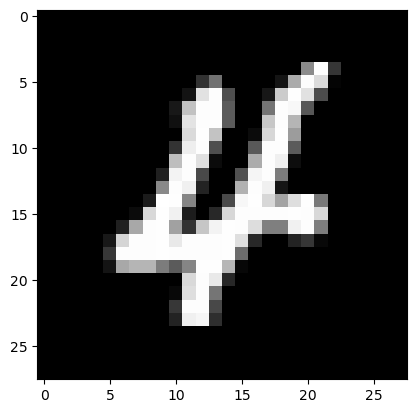

In [22]:
tensor, label = test_data[idx_random_tensor]

print("Testing data set item:", idx_random_tensor)
print("Label:", label)
print("Predicted :", predict_image(tensor, model))

plt.imshow(tensor[0, :, :], cmap="gray")

plt.show()

## Saving and loading the Model

The model parameters (weights and biases) are returned by the `state_dict()` method.

The model parameters can be saved to a file.

In [25]:
# torch.save(model.state_dict(), "mnist-model.pth")

A saved model can be read from file.

In [26]:
# model = MnistModel()
# model.load_state_dict(torch.load("mnist-model.pth"))

## Project proposals

1. **Example** <br>